# <p align="center">Big Data Frameworks</p>

### <p align="center">Analyse d’une trace de données de Google</p>

Thomas GOUTH, Théo MILLOT, Lucas RICARDE, David SZWARCBART

ING 3 HPDA

Année 2024-2025

## Loading of data


In [ ]:
!pip install gsutil
!pip install statsmodels

In [ ]:
!gsutil -m cp -R gs://clusterdata-2011-2/task_usage/ /content

In [ ]:
!gsutil -m cp -R gs://clusterdata-2011-2/task_events/ /content

## Spark initialisation

In [3]:
import os
from pyspark.sql import SparkSession

# Install PySpark via pip
!pip install pyspark

# Correct Spark session initialization by fixing the JAVA_HOME path
# Ensure the correct JDK version is installed and set the environment variable
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

# Ensure Java installation is valid
!apt-get update && apt-get install -y openjdk-11-jdk-headless

# Start Spark Session
spark = SparkSession.builder \
        .appName("Deepnote Spark Session") \
        .master("local[*]") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

spark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,698 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,610 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubunt

In [4]:
sc = spark.sparkContext

In [5]:
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, max, sum, min
from pyspark import StorageLevel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import statsmodels.api as sm

## Data to RDD

In [7]:
full_RDD = sc.textFile("/content/task_usage/*").map(lambda line: line.split(",")).persist(StorageLevel.MEMORY_AND_DISK)

In [8]:
full_RDD = sc.textFile("/content/task_usage/part-00000-of-00500.csv.gz").map(lambda line: line.split(",")).persist(StorageLevel.MEMORY_AND_DISK)

## Dominants jobs

In [9]:
full_jobsM = full_RDD.map(lambda cols: (int(cols[2]), (1, float(cols[5]), float(cols[19]), float(cols[6]), float(cols[10]))))
f_full_jobs = full_jobsM.filter(lambda x: x[1][1]>0 and x[1][2]>0 and x[1][1]<1 and x[1][2]<1 and x[0]>0 and x[1][4]>0 and x[1][3]>0 and x[1][4]<1 and x[1][3]<1)
r_full_jobs = f_full_jobs.reduceByKey(lambda a, b: (a[0] + b[0], a[1]+b[1], np.max([a[2],b[2]]), a[3]+b[3], np.max([a[4],b[4]])))
end_full_jobs = r_full_jobs.mapValues(lambda x: (x[0], x[1]/x[0], x[2], x[3]/x[0], x[4])).persist(StorageLevel.MEMORY_AND_DISK)

In [10]:
jobs_dom_cpuavg = end_full_jobs.sortBy(lambda x: (x[1][1]), ascending=False).keys().take(10)
jobs_dom_cpumax = end_full_jobs.sortBy(lambda x: (x[1][2]), ascending=False).keys().take(10)
jobs_dom_memavg = end_full_jobs.sortBy(lambda x: (x[1][3]), ascending=False).keys().take(10)
jobs_dom_memmax = end_full_jobs.sortBy(lambda x: (x[1][4]), ascending=False).keys().take(10)

In [11]:
print(jobs_dom_cpuavg)
print(jobs_dom_cpumax)
print(jobs_dom_memavg)
print(jobs_dom_memmax)

[5501666014, 6184967359, 6243111979, 2509801316, 4974863111, 4974863530, 4974862840, 4974863723, 4974862115, 4974863081]
[5022579678, 4665897969, 4665712396, 5501666014, 6184967359, 6176114691, 4665712499, 6251803864, 6127642576, 4974912787]
[6024393894, 6184967406, 6184967359, 4472621957, 5840251953, 259235987, 3638155221, 5323518598, 2509801316, 3405957923]
[6024393894, 6184967406, 6184967359, 4472621957, 5840251953, 259235987, 3638155221, 5323518598, 2509801316, 3405957923]


## Dominants tasks

In [12]:
fullM = full_RDD.map(lambda cols: ((int(cols[2]), int(cols[3])), (1, float(cols[5]), float(cols[19]), float(cols[6]), float(cols[10]))))
f_full = fullM.filter(lambda x: x[1][1]>0 and x[1][2]>0 and x[1][1]<1 and x[1][2]<1 and x[0][1]>0 and x[1][4]>0 and x[1][3]>0 and x[1][4]<1 and x[1][3]<1 and x[0][0]>0)
r_full = f_full.reduceByKey(lambda a, b: (a[0] + b[0], a[1]+b[1], np.max([a[2],b[2]]), a[3]+b[3], np.max([a[4],b[4]])))
end_full = r_full.mapValues(lambda x: (x[0], x[1]/x[0], x[2], x[3]/x[0], x[4])).persist(StorageLevel.MEMORY_AND_DISK)

In [21]:
tasks_dom_cpuavg = end_full.sortBy(lambda x: (x[1][1]), ascending=False).take(15)
tasks_dom_cpumax = end_full.sortBy(lambda x: (x[1][2]), ascending=False).take(15)
tasks_dom_memavg = end_full.sortBy(lambda x: (x[1][3]), ascending=False).take(15)
tasks_dom_memmax = end_full.sortBy(lambda x: (x[1][4]), ascending=False).take(15)

In [22]:
def rdd_to_pandasdf(rdd_list) :
    df_correlation=pd.DataFrame(columns=['job ID', 'task index', 'number of tasks', 'Average CPU rate', 'Max CPU rate', 'Average memory usage', 'Max memory usage'])
    for job_list in rdd_list :
      df = pd.DataFrame(job_list, columns=['jobs ID', 'values'])
      df_keys = pd.DataFrame(df['jobs ID'].tolist(), columns=['job ID', 'task index'])
      df_values = pd.DataFrame(df['values'].tolist(), columns=['number of tasks', 'Average CPU rate', 'Max CPU rate', 'Average memory usage', 'Max memory usage'])
      df_final = df_keys.join(df_values)
      df_correlation = pd.concat([df_correlation, df_final], ignore_index=True)

    return (df_correlation)


In [23]:
df_tasks_dom = rdd_to_pandasdf([tasks_dom_cpuavg, tasks_dom_cpumax, tasks_dom_memavg, tasks_dom_memmax])

<ipython-input-22-6c1fd0790263>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_correlation = pd.concat([df_correlation, df_final], ignore_index=True)


In [24]:
df_tasks_dom

,job ID,task index,number of tasks,Average CPU rate,Max CPU rate,Average memory usage,Max memory usage
0,6251620795,5,2,0.268300,0.370600,0.084595,0.084960
1,4665897969,44,17,0.252841,0.418000,0.066636,0.067870
2,6251684909,5,18,0.251591,0.356000,0.072699,0.111500
3,4665897969,46,17,0.251265,0.754900,0.066864,0.068730
4,6251658528,2,5,0.248060,0.412600,0.013139,0.015150
5,4665897969,228,17,0.245165,0.470700,0.068318,0.068730
6,4665897969,254,17,0.243459,0.475600,0.067541,0.068600
7,6251684909,7,19,0.242747,0.384800,0.066786,0.111600
8,4665897969,191,17,0.241182,0.403300,0.064988,0.070560
9,4665897969,79,17,0.240918,0.349100,0.065983,0.069340


## Dominants jobs by priority

In [25]:
folder_path = '/content/task_events'

df_tasks_dom_prio = df_tasks_dom

for filename in os.listdir(folder_path):

    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)
    df.columns = ["time", "missing info", "job ID", "task index", "machine ID", "event type", "user", "scheduling class", "priority",
           "CPU request", "memory request", "disk space request", "different machines restriction"]
    df_iter = df[['job ID', 'task index', 'priority']].drop_duplicates()
    df_tasks_dom_prio = pd.merge(df_tasks_dom_prio, df_iter, on=['job ID', 'task index'], how='left', suffixes=(f'_x{filename}', f'_y{filename}'))

df_tasks_dom_prio["priority"] = df_tasks_dom_prio.iloc[:,7:].mean(axis=1, skipna=True)
df_tasks_dom_prio.drop(df_tasks_dom_prio.columns[7:-1],axis=1,inplace=True)

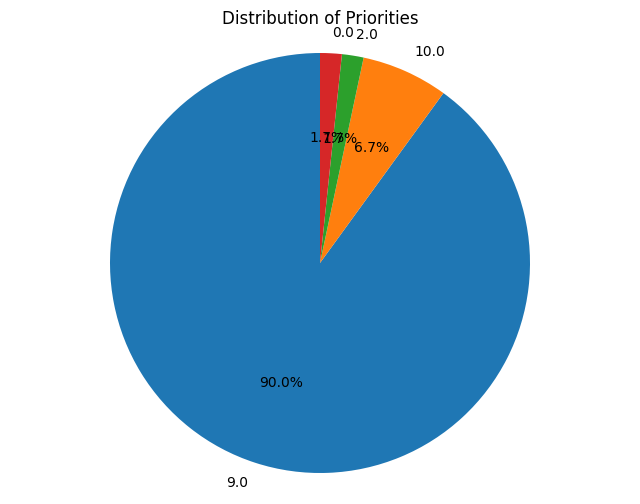

In [26]:
priority_counts = df_tasks_dom_prio['priority'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(priority_counts, labels=priority_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Priorities")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Memory usage and CPU usage correlation for dominants tasks

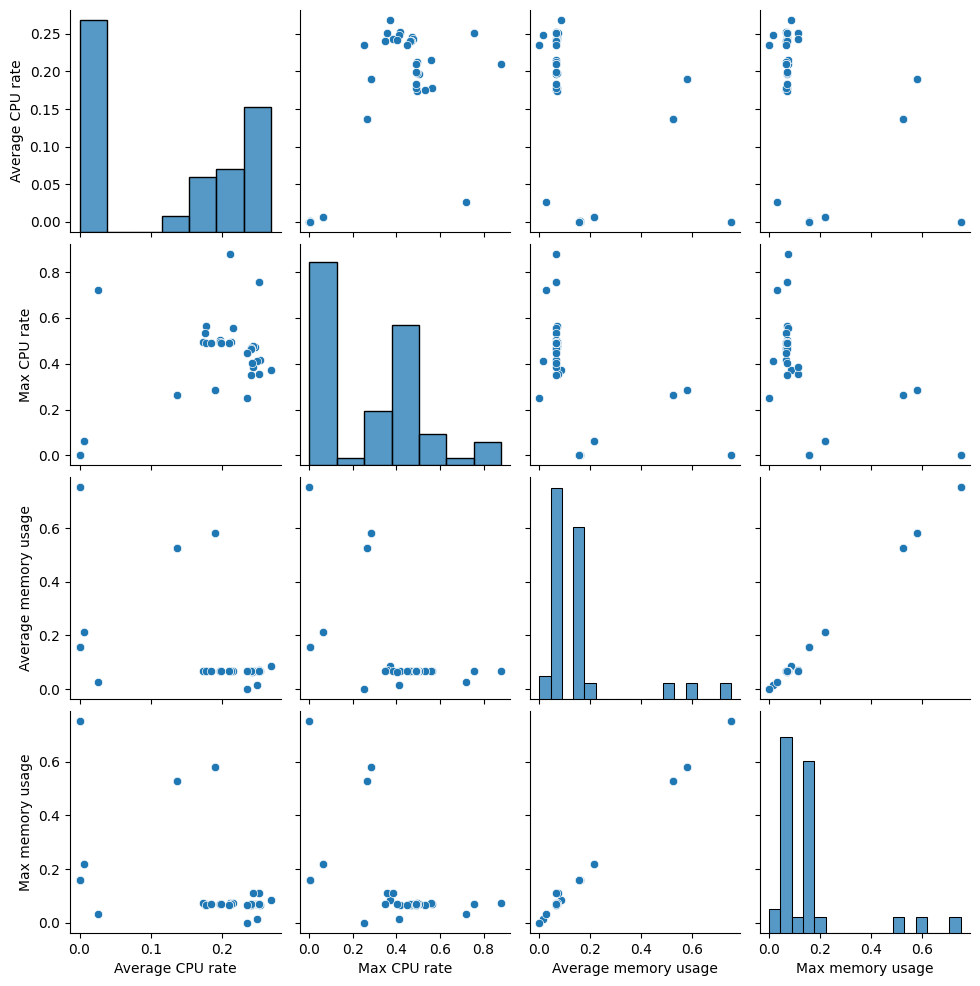

In [27]:
sns.pairplot(df_tasks_dom[['Average CPU rate','Max CPU rate','Average memory usage','Max memory usage']])

                             OLS Regression Results                             
Dep. Variable:     Average memory usage   R-squared:                       0.108
Model:                              OLS   Adj. R-squared:                  0.092
Method:                   Least Squares   F-statistic:                     6.988
Date:                  Sun, 23 Feb 2025   Prob (F-statistic):             0.0105
Time:                          21:52:28   Log-Likelihood:                 26.565
No. Observations:                    60   AIC:                            -49.13
Df Residuals:                        58   BIC:                            -44.94
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

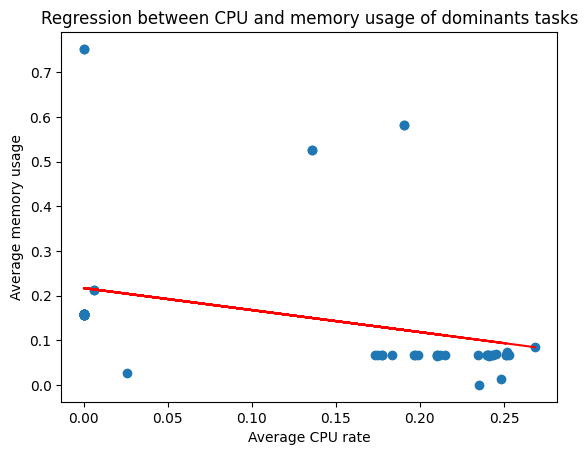

In [28]:
x = sm.add_constant(df_tasks_dom['Average CPU rate'])
model = sm.OLS(df_tasks_dom['Average memory usage'], x).fit()
y_pred = model.predict(x)

print(model.summary())

fig, ax = plt.subplots()
ax.scatter(df_tasks_dom['Average CPU rate'], df_tasks_dom['Average memory usage'])
plt.plot(df_tasks_dom['Average CPU rate'], y_pred, color='red')
plt.xlabel('Average CPU rate')
plt.ylabel('Average memory usage')
plt.title("Regression between CPU and memory usage of dominants tasks")
plt.show()